In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_cars = pd.read_csv('Electric_cars_vehicle_spec.csv')
df_cars.head()

,VehicleType,Make,BodyType,Model,StartingPrice(INR Lakhs),NoofSeats,MaxTorque(Nm),MaxPower(BHP),Range(km/charge),BatteryCapacity(kwh),ChargingTime(Mins),GroundClearance(mm),BootSpace(Liters),FastCharging
0,Car,Tata,SUV,Tata Punch EV,10.99,5,190Nm,120.69 - 80.46bhp,315 - 421 km/charge,25 - 35kwh,50Mins,190 mm,366 Liters,NaN
1,Car,Tata,SUV,Tata Nexon EV,14.74,5,215Nm,127.39 - 142.68bhp,325 - 465 km,30 - 40.5 kwh,6H -AC-7.2 kW (10-100%),190 mm,350 Liters,Yes
2,Car,Kia,SUV,Kia EV6,60.95,5,605Nm,225.86 - 320.55bhp,708 km,77.4 kwh,18 Min (0-80%),NaN,NaN,Yes
3,Car,Tata,Hatchback,Tata Tiago EV,8.69,5,114Nm,60.34 - 73.75bhp,250 - 315 km/charge,19.2 - 24 kwh,58 min| DC-25 kW(10-80%),NaN,240 Liters,Yes
4,Car,Mahindra,SUV,Mahindra XUV400 EV,15.49,5,310Nm,147.51 - 149.55bhp,375 - 456 kms,34.5 - 39.4 kwh,6H 30 Min-AC-7.2 kW (0-100%),NaN,NaN,Yes


In [3]:
df_cars.columns

Index(['VehicleType', 'Make', 'BodyType', 'Model', 'StartingPrice(INR Lakhs)',
       'NoofSeats', 'MaxTorque(Nm)', 'MaxPower(BHP)', 'Range(km/charge)',
       'BatteryCapacity(kwh)', 'ChargingTime(Mins)', 'GroundClearance(mm)',
       'BootSpace(Liters)', 'FastCharging'],
      dtype='object')

In [4]:
df_cars['MaxTorque(Nm)'] = df_cars['MaxTorque(Nm)'].str.replace("Nm@1000rpm","").str.replace("Nm","")
df_cars['MaxPower(BHP)'] = df_cars['MaxPower(BHP)'].str.replace("bhp","").str.replace("kw","")

df_cars['Range(km/charge)'] = df_cars['Range(km/charge)'].str.replace(" km/charge","").str.replace("km","").str.replace(" s","").str.strip()
df_cars['BatteryCapacity(kwh)'] = df_cars['BatteryCapacity(kwh)'].str.replace("kwh","").str.replace("kw","").str.strip()
df_cars['FastCharging'] = np.where(df_cars['FastCharging'].isna(),"No",df_cars['FastCharging'])

df_cars['MinPower(BHP)'] = df_cars['MaxPower(BHP)'].str.split("-").str[0]
df_cars['Max_Power(BHP)'] = df_cars['MaxPower(BHP)'].str.split("-").str[-1]
df_cars[['MinPower(BHP)', 'Max_Power(BHP)']] = df_cars[['MinPower(BHP)', 'Max_Power(BHP)']].astype('float')
df_cars['AvgPower (BHP)'] = (df_cars['MinPower(BHP)'] + df_cars['Max_Power(BHP)'])/2

df_cars['Min_Range'] = df_cars['Range(km/charge)'].str.split("-").str[0]
df_cars['Max_Range'] = df_cars['Range(km/charge)'].str.split("-").str[-1]
df_cars['Max_Range'].iloc[19] = 452
df_cars[['Min_Range','Max_Range']] = df_cars[['Min_Range','Max_Range']].astype('float')
df_cars['Avg_Range(km/charge)'] = (df_cars['Min_Range']+df_cars['Max_Range'])/2

df_cars['Min_BC'] = df_cars["BatteryCapacity(kwh)"].str.split(" - ").str[0]
df_cars['Max_BC'] = df_cars["BatteryCapacity(kwh)"].str.split(" - ").str[-1]
df_cars[['Min_BC', 'Max_BC']] = df_cars[['Min_BC', 'Max_BC']].astype('float')
df_cars['AvgBatteryCapacity(kwh)'] = (df_cars['Min_BC']+df_cars['Max_BC'])/2
df_cars['MaxTorque(Nm)'] = df_cars['MaxTorque(Nm)'].astype('float')
cols = ['VehicleType', 'MaxPower(BHP)', 'Range(km/charge)', 'BatteryCapacity(kwh)', 'ChargingTime(Mins)',
 'GroundClearance(mm)', 'BootSpace(Liters)', 'MinPower(BHP)', 'Max_Power(BHP)', 
 'Min_Range', 'Max_Range', 'Min_BC', 'Max_BC']

df_cars = df_cars.drop(index=11).reset_index(drop=True)

df_cars2 = df_cars.drop(columns=cols)
df_cars2.head()


,Make,BodyType,Model,StartingPrice(INR Lakhs),NoofSeats,MaxTorque(Nm),FastCharging,AvgPower (BHP),Avg_Range(km/charge),AvgBatteryCapacity(kwh)
0,Tata,SUV,Tata Punch EV,10.99,5,190.0,No,100.575,368.0,30.00
1,Tata,SUV,Tata Nexon EV,14.74,5,215.0,Yes,135.035,395.0,35.25
2,Kia,SUV,Kia EV6,60.95,5,605.0,Yes,273.205,708.0,77.40
3,Tata,Hatchback,Tata Tiago EV,8.69,5,114.0,Yes,67.045,282.5,21.60
4,Mahindra,SUV,Mahindra XUV400 EV,15.49,5,310.0,Yes,148.530,415.5,36.95


In [5]:
df_cars2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Make                      35 non-null     object 
 1   BodyType                  35 non-null     object 
 2   Model                     35 non-null     object 
 3   StartingPrice(INR Lakhs)  35 non-null     float64
 4   NoofSeats                 35 non-null     int64  
 5   MaxTorque(Nm)             34 non-null     float64
 6   FastCharging              35 non-null     object 
 7   AvgPower (BHP)            34 non-null     float64
 8   Avg_Range(km/charge)      35 non-null     float64
 9   AvgBatteryCapacity(kwh)   34 non-null     float64
dtypes: float64(5), int64(1), object(4)
memory usage: 2.9+ KB


In [6]:
df_cars2.describe()

,StartingPrice(INR Lakhs),NoofSeats,MaxTorque(Nm),AvgPower (BHP),Avg_Range(km/charge),AvgBatteryCapacity(kwh)
count,35.000000,35.000000,34.000000,34.000000,35.000000,34.000000
mean,81.722857,4.800000,467.705882,285.507059,451.657143,68.017353
std,72.948591,0.833137,264.048610,193.525965,140.878534,30.121185
min,4.500000,2.000000,50.000000,13.410000,160.000000,10.000000
25%,19.185000,5.000000,228.750000,134.333750,384.500000,37.512500
50%,60.950000,5.000000,462.000000,269.102500,444.000000,74.825000
75%,123.300000,5.000000,663.000000,402.225000,536.500000,90.815000
max,255.000000,7.000000,1015.000000,750.970000,857.000000,112.000000


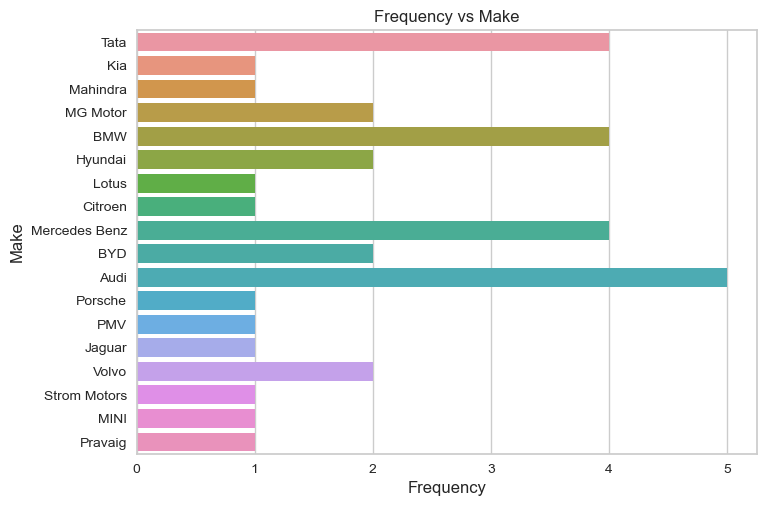

In [7]:
sns.countplot(y = df_cars2['Make'])
plt.title("Frequency vs Make")
plt.xlabel("Frequency")
plt.ylabel("Make")
plt.show()

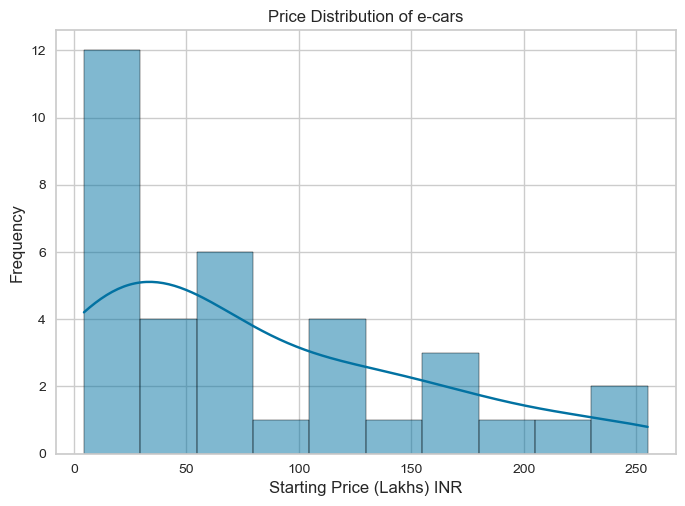

In [8]:
sns.histplot(df_cars2['StartingPrice(INR Lakhs)'], bins=10, kde=True)
plt.ylabel("Frequency")
plt.xlabel("Starting Price (Lakhs) INR")
plt.title("Price Distribution of e-cars")
plt.show()

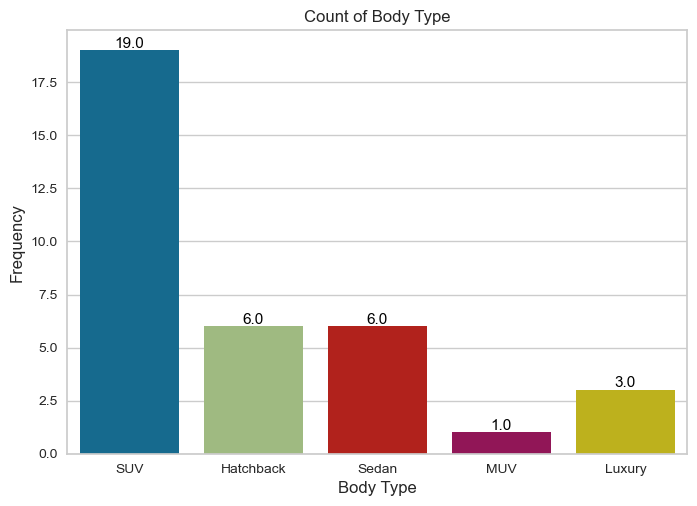

In [9]:
sns.countplot(x = df_cars2['BodyType'])
plt.xlabel("Body Type")
plt.ylabel("Frequency")
plt.title("Count of Body Type")
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.show()

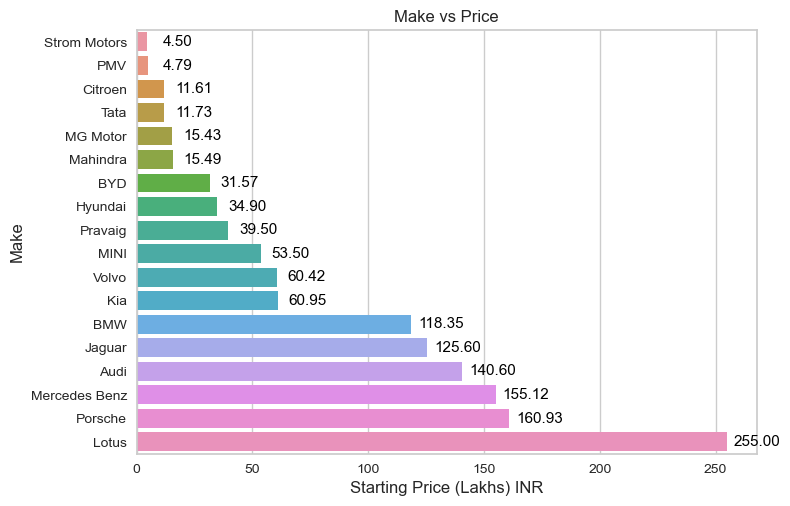

In [10]:
ind = df_cars2.groupby('Make')['StartingPrice(INR Lakhs)'].mean().sort_values().index
val = df_cars2.groupby('Make')['StartingPrice(INR Lakhs)'].mean().sort_values().values
sns.barplot(x = val, y=ind)
for p in plt.gca().patches:
    plt.gca().annotate(f"{p.get_width():.2f}", (p.get_width()+10, p.get_y() + p.get_height() / 2.),
                ha='center', va='center', fontsize=11, color='black', xytext=(5, 0),
                textcoords='offset points')
plt.xlabel("Starting Price (Lakhs) INR")
plt.title("Make vs Price")
plt.show()

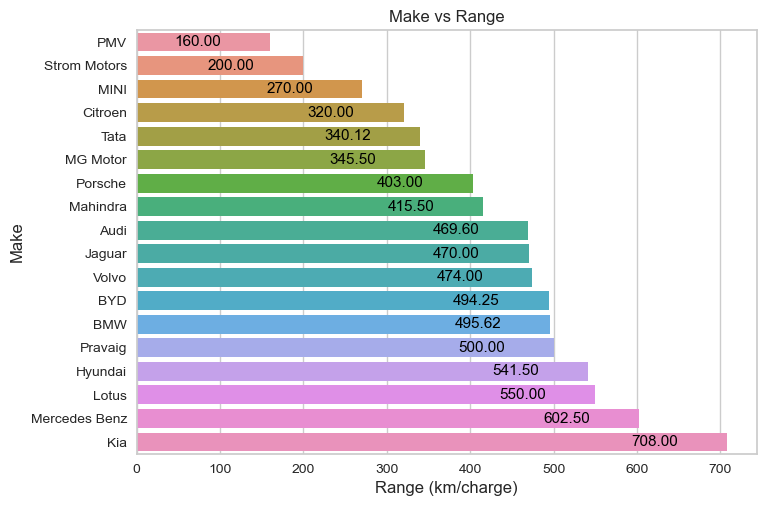

In [11]:
ind = df_cars2.groupby('Make')['Avg_Range(km/charge)'].mean().sort_values().index
val = df_cars2.groupby('Make')['Avg_Range(km/charge)'].mean().sort_values().values
sns.barplot(x = val, y=ind)
for p in plt.gca().patches:
    plt.gca().annotate(f"{p.get_width():.2f}", (p.get_width()-95, p.get_y() + p.get_height() / 2.),
                ha='center', va='center', fontsize=11, color='black', xytext=(5, 0),
                textcoords='offset points')
plt.xlabel("Range (km/charge)")
plt.title("Make vs Range")
plt.show()

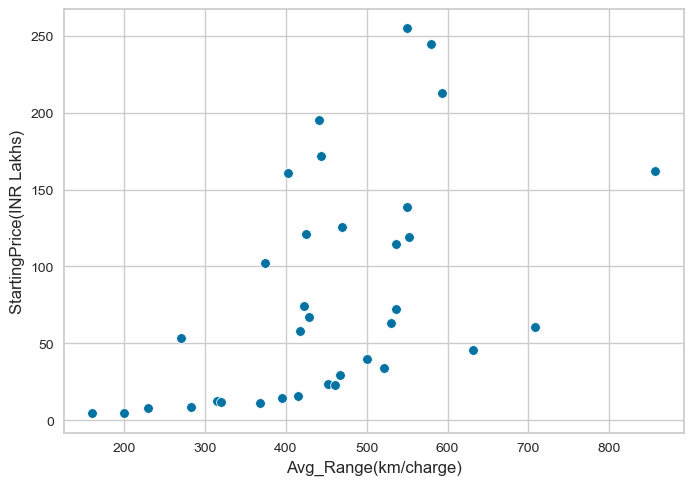

In [12]:
sns.scatterplot(x = df_cars2['Avg_Range(km/charge)'], y= df_cars2['StartingPrice(INR Lakhs)'])
plt.show()

In [13]:
df_cars2_clust = df_cars2[['StartingPrice(INR Lakhs)','FastCharging','Avg_Range(km/charge)']]
df_cars2_clust['FastCharging'] = np.where(df_cars2_clust['FastCharging']=='Yes',1,0)

In [14]:
ss= StandardScaler()
X = ss.fit_transform(df_cars2_clust)

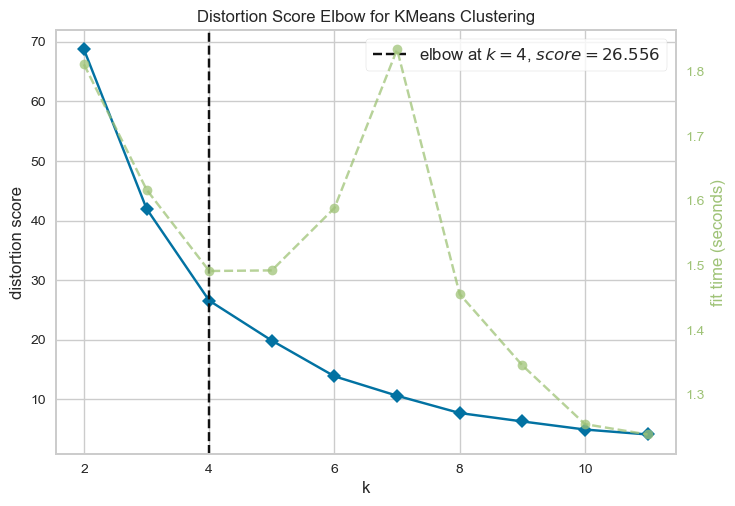

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [15]:

np.random.seed(1234)
model = KMeans(n_init=10)
visualizer = KElbowVisualizer(model, k=(2,12)).fit(X)
visualizer.show()

In [16]:
np.random.seed(1234)
model = KMeans(n_clusters=4, n_init=10)
k_mean = model.fit(X)    

In [17]:
k_mean.labels_

array([0, 1, 1, 1, 1, 0, 2, 1, 1, 1, 2, 1, 3, 0, 3, 1, 3, 1, 3, 0, 1, 3,
       2, 1, 0, 2, 1, 1, 1, 1, 2, 3, 1, 2, 3])

In [18]:
df_clus_ran_pr = pd.concat([df_cars2_clust, pd.DataFrame(k_mean.labels_, columns=['cluster'])], axis=1)
df_clus_ran_pr.head()

,StartingPrice(INR Lakhs),FastCharging,Avg_Range(km/charge),cluster
0,10.99,0,368.0,0
1,14.74,1,395.0,1
2,60.95,1,708.0,1
3,8.69,1,282.5,1
4,15.49,1,415.5,1


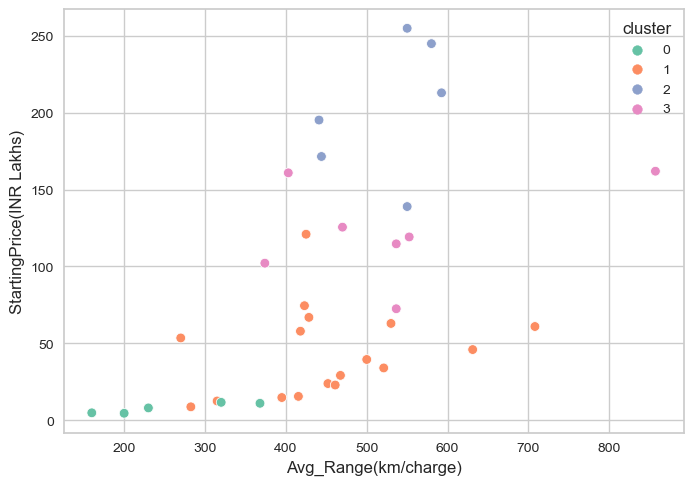

In [19]:
sns.scatterplot(x = df_clus_ran_pr['Avg_Range(km/charge)'],y = df_clus_ran_pr['StartingPrice(INR Lakhs)'], hue = df_clus_ran_pr['cluster'], palette='Set2')
plt.show()

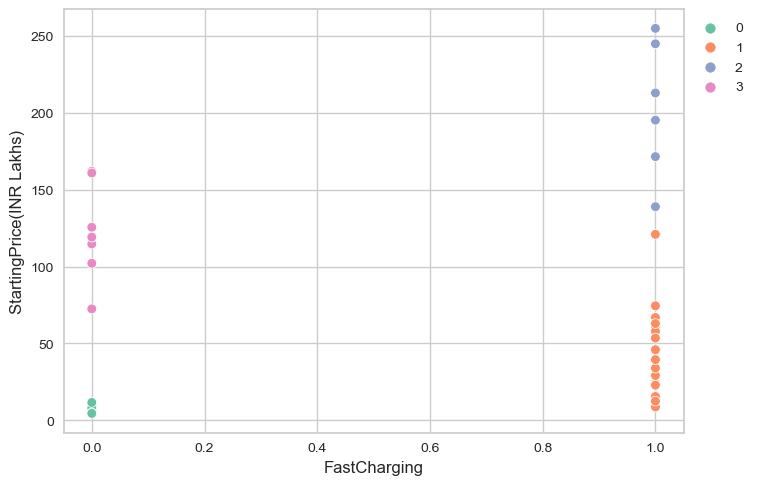

In [20]:
sns.scatterplot(x = df_clus_ran_pr['FastCharging'],y = df_clus_ran_pr['StartingPrice(INR Lakhs)'], hue = df_clus_ran_pr['cluster'], palette='Set2')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

In [21]:
df_bikes = pd.read_csv("electric_two_wheeler_specs.csv")
df_bikes.head()

,VehicleType,Make,Model,StartingPrice(INR Lakhs),Range(km/charge),BatteryCapacity(kwh),ChargingTime(Mins),Top Speed(km/Hr),KerbWeight(Kg),TyreType,GroundClearance(mm),FastCharging
0,Bikes,Revolt Motors,Revolt RV400,1.17,150 - 80-150 km/charge,3.24 Kwh,4.5 Hr,85 km/Hr,108 Kg,Tubeless,215 mm,NaN
1,Bikes,Ultraviolette,Ultraviolette F77,3.80,206 - 307 km/charge,10.3 Kwh,4 Hr,152 km/Hr,207 Kg,Tubeless,160 mm,Yes
2,Bikes,Tork,Tork Kratos,1.67,180 km/charge,NaN,6-7 Hr,105 km/Hr,140 Kg,Tubeless,165 mm,No
3,Bikes,Oben,Oben Rorr,1.50,200 km/charge,NaN,2 Hr,100 km/Hr,NaN,Tubeless,230 mm,Yes
4,Bikes,Komaki,Komaki Ranger,1.86,200-250 km/charge,NaN,6 Hr,NaN,NaN,Tubeless,NaN,NaN


In [22]:
df_bikes.columns

Index(['VehicleType', 'Make', 'Model', 'StartingPrice(INR Lakhs)',
       'Range(km/charge)', 'BatteryCapacity(kwh)', 'ChargingTime(Mins)',
       'Top Speed(km/Hr)', 'KerbWeight(Kg)', 'TyreType', 'GroundClearance(mm)',
       'FastCharging'],
      dtype='object')

In [23]:
df_bikes['Min_Range'] = df_bikes['Range(km/charge)'].str.replace("km/charge","").str.split("-").str[0]
df_bikes['Max_Range'] = df_bikes['Range(km/charge)'].str.replace("km/charge","").str.split("-").str[-1]
df_bikes[['Min_Range', 'Max_Range']] = df_bikes[['Min_Range', 'Max_Range']].astype('float')
df_bikes['AvgRange(km/charge)'] = (df_bikes['Min_Range'] + df_bikes['Max_Range'])/2
df_bikes['Top Speed(km/Hr)'] = df_bikes['Top Speed(km/Hr)'].str.replace(" km/Hr","")
df_bikes['FastCharging'] = np.where(df_bikes['FastCharging'].isna(),'No',df_bikes['FastCharging'])
df_bikes = df_bikes.drop(columns= ['KerbWeight(Kg)','TyreType','GroundClearance(mm)', 'BatteryCapacity(kwh)','ChargingTime(Mins)', 'Range(km/charge)', 'Min_Range','Max_Range', 'VehicleType'])
df_bikes = df_bikes.dropna(axis=0)
df_bikes['Top Speed(km/Hr)'] = df_bikes['Top Speed(km/Hr)'].astype('float')
df_bikes.head()

,Make,Model,StartingPrice(INR Lakhs),Top Speed(km/Hr),FastCharging,AvgRange(km/charge)
0,Revolt Motors,Revolt RV400,1.17,85.0,No,150.0
1,Ultraviolette,Ultraviolette F77,3.80,152.0,Yes,256.5
2,Tork,Tork Kratos,1.67,105.0,No,180.0
3,Oben,Oben Rorr,1.50,100.0,Yes,200.0
5,One Electric Motorcycles,One Electric Motorcycles Kridn,1.35,95.0,No,110.0


In [24]:
df_bikes2 = df_bikes[['AvgRange(km/charge)','Top Speed(km/Hr)','StartingPrice(INR Lakhs)', 'FastCharging']]
df_bikes2['FastCharging'] = np.where(df_bikes2['FastCharging']=='Yes',1,0)
ss = StandardScaler()
X = ss.fit_transform(df_bikes2)

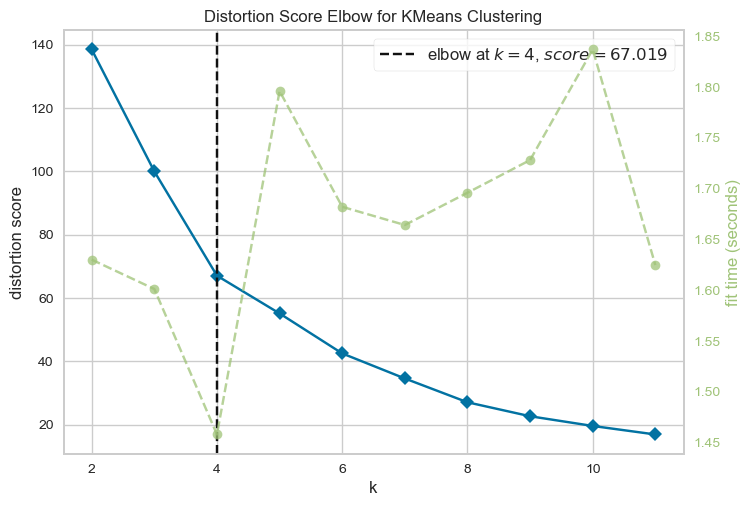

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [25]:
np.random.seed(1234)
model = KMeans(n_init=10)
visualizer = KElbowVisualizer(model, k=(2,12)).fit(X)
visualizer.show()

In [26]:
np.random.seed(1234)
model = KMeans(n_clusters=4, n_init=10)
k_mean = model.fit(X)    
k_mean.labels_

array([0, 3, 0, 2, 0, 0, 2, 3, 1, 1, 2, 0, 0, 2, 0, 2, 0, 1, 0, 0, 0, 2,
       2, 0, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1,
       1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 0, 1, 1, 1, 1])

In [27]:
df_bikes2['clusters'] = k_mean.labels_
df_bikes2

,AvgRange(km/charge),Top Speed(km/Hr),StartingPrice(INR Lakhs),FastCharging,clusters
0,150.0,85.0,1.17,0,0
1,256.5,152.0,3.80,1,3
2,180.0,105.0,1.67,0,0
3,200.0,100.0,1.50,1,2
5,110.0,95.0,1.35,0,0
7,160.0,110.0,1.90,0,0
9,120.0,100.0,1.63,1,2
10,221.0,135.0,3.60,1,3
11,100.0,65.0,1.08,0,1
13,100.0,25.0,0.70,0,1


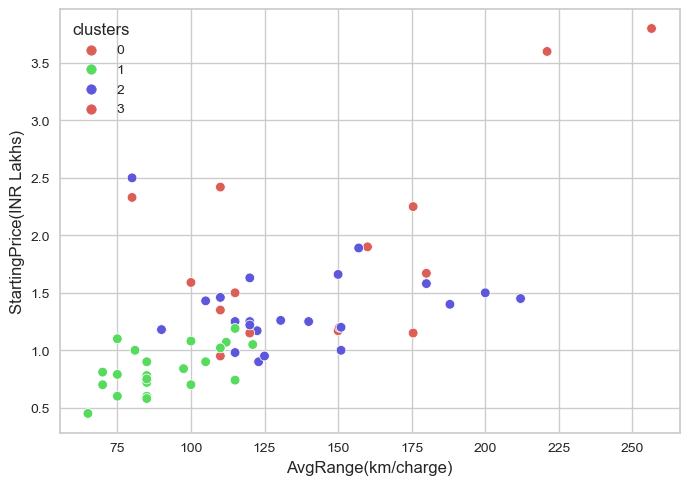

In [28]:
sns.scatterplot(x = df_bikes2['AvgRange(km/charge)'],y = df_bikes2['StartingPrice(INR Lakhs)'], hue = df_bikes2['clusters'], palette='hls')
plt.show()

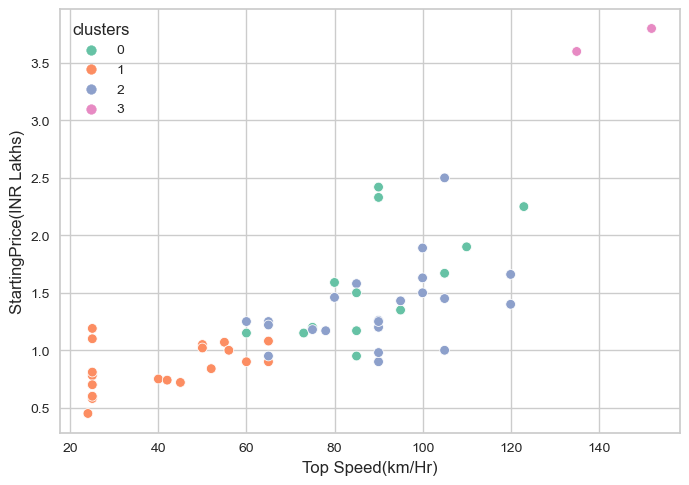

In [29]:
sns.scatterplot(x = df_bikes2['Top Speed(km/Hr)'].sort_values(), y = df_bikes2['StartingPrice(INR Lakhs)'], hue = df_bikes2['clusters'], palette='Set2')
plt.show()